In [1]:
import processes.cosmology as cosmology
import processes.synchro as synchro
import processes.ic as ic
import processes.spectra as spec
import processes.ebl as ebl
import processes.gamma_gamma as gamma_gamma
############################################################################
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import subprocess  # to run prompt scripts from python
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy import interpolate
from scipy import stats
############################################################################
from test_pytorch import *
from functools import partial

Hey!
If cuda is available:  True
Using 'cuda'!!!
NVIDIA GeForce RTX 2060


# Geometry, energy range and other common parameters

In [2]:
z = 0.361  # http://linker.aanda.org/10.1051/0004-6361/201833618/54
r_blr = (0.036 * u.pc).to(u.cm)  # BLR radius
print("r_blr = {:.3e}".format(r_blr))
d_l = cosmology.luminosity_distance(z).to(u.cm)
print("d_l = {:.3e} = {:.3e}".format(d_l.to(u.cm), d_l.to(u.Mpc)))

r_blr = 1.111e+17 cm
d_l = 6.125e+27 cm = 1.985e+03 Mpc


path to photon field file (6852 strings):

In [3]:
field = "data/PKS1510-089/nph"

minimum, maximum observable energies, reference energy for spectrum laws:

In [4]:
e_min_value = 1.0e+08  # eV
e_max_value = 1.0e+12  # eV
en_ref = 1.0e+10  # eV

calculation of gamma-gamma interaction rate on the given photon field:

In [5]:
E_gamma, r_gamma_gamma = gamma_gamma.interaction_rate(
    field,
    e_min_value * u.eV,
    e_max_value * u.eV,
    background_photon_energy_unit=u.eV,
    background_photon_density_unit=(u.eV * u.cm**3)**(-1)
)

1. Creating .o files...
Done!
2. Creating an .so library file...
Done!
3. Installing the module...
b'running install\nrunning build\nrunning build_ext\nrunning install_lib\nrunning install_egg_info\nRemoving /home/raylend/anaconda3/envs/pytorch-test/lib/python3.8/site-packages/gamma_gamma_interaction_rate_ext-0.1.0-py3.8.egg-info\nWriting /home/raylend/anaconda3/envs/pytorch-test/lib/python3.8/site-packages/gamma_gamma_interaction_rate_ext-0.1.0-py3.8.egg-info'
Done!
4.Installation of gamma-gamma interaction rate library completed.


## Definition of log-parabolic spectrum

In [6]:
def my_spec(en, alpha, beta, norm_scaled,
            scale_norm=1):
    norm = scale_norm * norm_scaled
    return(spec.log_parabola(en, alpha, beta, en_ref=en_ref, norm=norm))

## Telescope data

In [7]:
# Data Fermi-LAT
data_fermi = np.loadtxt(
    'data/PKS1510-089/4FGL J1512.8-0906_Fermi-LAT_energy_SED_downerror_uperror.txt'
)
data_en_fermi = data_fermi[:, 0] * 1.0e+06  # MeV -> eV
data_sed_fermi = data_fermi[:, 1] * 1.0e+06  # MeV -> eV
data_down_fermi = data_fermi[:, 2] * 1.0e+06  # MeV -> eV
data_up_fermi = data_fermi[:, 3] * 1.0e+06  # MeV -> eV
NUMBER_OF_FERMI_DOTS = data_en_fermi.shape[0]
yerr_stat_fermi = [data_down_fermi, data_up_fermi]
# Data magic
data_magic = np.loadtxt(
    'data/PKS1510-089/4FGL J1512.8-0906_MAGIC_energy_SED_downerror_uperror.txt')
data_en_magic = data_magic[:, 0] * 1.0e+06  # MeV -> eV
data_sed_magic = data_magic[:, 1] * 1.0e+06  # MeV -> eV
data_down_magic = data_magic[:, 2] * 1.0e+06  # MeV -> eV
data_up_magic = data_magic[:, 3] * 1.0e+06  # MeV -> eV
yerr_stat_magic = [data_down_magic, data_up_magic]
#########################################################################
data_syst_magic_up = np.loadtxt(
    "data/PKS1510-089/MAGIC_systematics_up.txt" # boundary, not difference!
)
syst_magic_en_up = data_syst_magic_up[:, 0] * 1.0e+09 # GeV -> eV
syst_magic_sed_up = data_syst_magic_up[:, 1] * 1.0e+12  # TeV -> eV
data_syst_magic_down = np.loadtxt(
    "data/PKS1510-089/MAGIC_systematics_down.txt" # boundary, not difference!
)
syst_magic_en_down = data_syst_magic_down[:, 0] * 1.0e+09  # GeV -> eV
syst_magic_sed_down = data_syst_magic_down[:, 1] * 1.0e+12  # TeV -> eV
syst_magic_en_common = np.sort(np.concatenate(
    [syst_magic_en_down, syst_magic_en_up]
))

In [8]:
# f_aux_syst_magic_interpolated_down_function = interpolate.interp1d(
#         np.log10(syst_magic_en_down), np.log10(syst_magic_sed_down),
#         kind='linear',
#         copy=True,
#         bounds_error=False,
#         fill_value='extrapolate'
# )
# def syst_magic_interpolated_down_function(e):
#     return(10.0**f_aux_syst_magic_interpolated_down_function(np.log10(e)))

# f_aux_syst_magic_interpolated_up_function = interpolate.interp1d(
#         np.log10(syst_magic_en_up), np.log10(syst_magic_sed_up),
#         kind='linear',
#         copy=True,
#         bounds_error=False,
#         fill_value='extrapolate'
# )
# def syst_magic_interpolated_up_function(e):
#     return(10.0**f_aux_syst_magic_interpolated_up_function(np.log10(e)))

# f_aux_measurement_magic_interpolated = interpolate.interp1d(
#         np.log10(data_en_magic), np.log10(data_sed_magic),
#         kind='linear',
#         copy=True,
#         bounds_error=False,
#         fill_value='extrapolate'
# )
# def measurement_magic_interpolated(e):
#     return(10.0**f_aux_measurement_magic_interpolated(np.log10(e)))

In [9]:
x_data = [np.concatenate([data_en_fermi, data_en_magic], axis=0), # central dots
          np.concatenate([data_en_fermi, syst_magic_en_down], axis=0), # down dots
          np.concatenate([data_en_fermi, syst_magic_en_up], axis=0)] # up dots
y_data = [np.concatenate([data_sed_fermi, data_sed_magic], axis=0), # central dots
          np.concatenate([data_sed_fermi, syst_magic_sed_down], axis=0), # down dots
          np.concatenate([data_sed_fermi, syst_magic_sed_up], axis=0)] # up dots
# statistical MAGIC errors are the same!
yerr_stat = [
    np.concatenate([yerr_stat_fermi[0],
                    yerr_stat_magic[0]],
                   axis=0),
    np.concatenate([yerr_stat_fermi[1],
                    yerr_stat_magic[1]],
                   axis=0)
]
en_observable = np.logspace(np.log10(e_min_value),
                            np.log10(e_max_value),
                            100)

# Internal absorption-only model (model 0)

## Model 0 SED function

In [10]:
scale_norm = 1e-19
scale_x = 1e+17

In [11]:
def model0_SED(en_observable, alpha, beta, norm_scaled,
               E_gamma=E_gamma,
               r_gamma_gamma=r_gamma_gamma,
               redshift=z,
               scale_norm=scale_norm
):
    en_source = en_observable * (1.0 + redshift)
    SED = en_source**2 * my_spec(en_source, alpha, beta, norm_scaled, scale_norm=scale_norm)
    r_gamma_gamma = spec.to_current_energy(en_source * u.eV,
                                           E_gamma,
                                           r_gamma_gamma).value
    SED = SED * np.exp(-ebl.tau_gilmore(en_observable * u.eV, z))
    SED = SED / (1.0 + redshift)
    return SED

## Function to fit the data with the model 0 SED function

In [12]:
# def fit_data_model0(f, x_data, y_data, y_sigma, p0,
#                     bounds=(-np.inf, np.inf),
#                     scale_norm=1e-19,
#                     scale_x=1e+17):
#     popt, pcov = curve_fit(f, x_data, y_data, p0=p0, sigma=y_sigma,
#                             absolute_sigma=True, check_finite=True,
#                             bounds=bounds,
#                             method='trf', 
#                             ftol=1e-10,
#                             xtol=1e-10,
#                             gtol=1e-10,
#                             x_scale=1.0, # 'jac'
#                             loss='linear',
#                             f_scale=1.0)
#     print("---------------------------------------------------------------")
#     print("The following parameters have been obtained:")
#     print(
#         "alpha = {:e} +/- {:e}".format(popt[0], np.sqrt(np.diag(pcov)[0])))
#     print(
#         "beta = {:e} +/- {:e}".format(popt[1], np.sqrt(np.diag(pcov)[1])))
#     print(
#         "norm = {:e} +/- {:e}".format(popt[2], np.sqrt(np.diag(pcov)[2])))
#     print("x = {:e} +/- {:e} = \n= {:f} +/- {:f} [R_BLR]".format(
#         popt[3],
#         np.sqrt(
#             np.diag(
#                 pcov)[3]),
#         (popt[3] /
#          (r_blr.value / scale_x)), (np.sqrt(
#              np.diag(
#                  pcov)[3]
#          ) /
#             (r_blr.value / scale_x))
#     )
#     )
#     #####################################################################
#     # calculate chi^2
#     data_predicted_from_fit = f(x_data, *popt)
#     chi_sq = np.sum((y_data - data_predicted_from_fit)**2 / y_sigma**2)
#     ndof = (y_data.shape[0] - len(popt) - 1)
#     print("n.d.o.f. = {:d}".format(ndof))
#     print("chi_sq / n.d.o.f. = {:f}".format(
#         chi_sq /
#         ndof)
#     )
#     return (popt, np.sqrt(np.diag(pcov)), chi_sq, ndof)

In [13]:
# def residual_func(pars,
#                   x_data=x_data,
#                   y_data=y_data,
#                   y_sigma=True,
#                   f=model0_SED):
#     model = f(x_data, *pars)
#     res = np.zeros(x_data.shape)
#     if y_sigma:
#         for i, value in enumerate(model):
#             if (value - y_data[i]) < 0: # using down errors
#                 if i >= NUMBER_OF_FERMI_DOTS: # MAGIC data
#                     syst_err = (measurement_magic_interpolated(x_data[i]) -
#                                 syst_magic_interpolated_down_function(x_data[i]))
#                     err = (yerr_stat[0][i]**2 + syst_err**2)**0.5
#                 else: # Fermi-LAT data
#                     err = yerr_stat[0][i]
#             else: # using up errors
#                 if i >= NUMBER_OF_FERMI_DOTS: # MAGIC data
#                     syst_err = (syst_magic_interpolated_up_function(x_data[i]) -
#                                 measurement_magic_interpolated(x_data[i]))
#                     err = (yerr_stat[1][i]**2 + syst_err**2)**0.5
#                 else: # Fermi-LAT data
#                     err = yerr_stat[1][i]
#             res[i] = (value - y_data[i]) / err
#     else:
#         res = (model - y_data)
#     return res

In [14]:
def residual_func(pars,
                  x_data=x_data,
                  y_data=y_data,
                  sigma=True,
                  yerr_stat=yerr_stat,
                  f=model0_SED):
    model = f(x_data, *pars)
    res = np.zeros(x_data.shape)
    if sigma:
        for i, value in enumerate(model):
            if (value - y_data[i]) < 0: # using down errors
                err = yerr_stat[0][i]
            else: # using up errors
                err = yerr_stat[1][i]
            res[i] = (value - y_data[i]) / err
    else:
        res = (model - y_data)
    return res

## Fitting to the data 

In [15]:
x0 = [2.5, 0.09, 2.7]
bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

In [16]:
optimized = []
for i in range(0, len(x_data)):
    print(i)
    optimized.append(
        least_squares(
            residual_func,
            x0,
            jac='3-point',
            bounds=bounds,
            method='trf', 
            ftol=1e-11,
            xtol=1e-11,
            gtol=1e-11,
            x_scale=1.0, # 'jac'
            loss='linear',
            f_scale=1.0,
            diff_step=None,
            tr_solver=None,
            tr_options={},
            jac_sparsity=None,
            max_nfev=None,
            verbose=2,
            args=(),
            kwargs={
                'x_data': x_data[i],
                'y_data': y_data[i],
                'sigma': True,
                'yerr_stat': yerr_stat,
                'f': model0_SED
            }
        )
    )
    print(optimized[i]['message'])
    print("Success: {}".format(optimized[i]['success']))
    print("Residual chi squared: ", 2.0 * optimized[i]['cost'])
    print("Best-fit parameters: ", optimized[i]['x'])
    print("-----------------------------------------------------------------------------")

0
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1345e+04                                    2.00e+05    
       1              3         3.7286e+03      7.62e+03       3.65e-02       1.80e+05    
       2              4         4.5607e+02      3.27e+03       7.30e-02       9.00e+04    
       3              5         3.2622e+01      4.23e+02       1.46e-01       3.78e+03    
       4              6         3.1319e+01      1.30e+00       1.30e-02       8.29e+00    
       5              7         3.1312e+01      7.51e-03       5.45e-03       1.65e+00    
       6              8         3.1311e+01      1.96e-04       8.42e-04       2.13e-01    
       7              9         3.1311e+01      5.09e-06       1.37e-04       3.30e-02    
       8             10         3.1311e+01      1.32e-07       2.20e-05       5.27e-03    
       9             11         3.1311e+01      3.42e-09       3.54e-06       8.48e-04  

In [17]:
popt_null_model= []
for i in range(0, len(optimized)):
    popt_null_model.append(optimized[i]['x'])
popt_null_model

[array([2.63888049, 0.06429406, 2.83990813]),
 array([2.65349789, 0.06700694, 2.79147876]),
 array([2.62921538, 0.06248744, 2.87195044])]

In [18]:
ndof_null_model = x_data[0].shape[0] - popt_null_model[0].shape[0] - 1
ndof_null_model

14

In [19]:
chisq_null_model = []
for i in range(0, len(optimized)):
    chisq_null_model.append(
        np.sum(
            (residual_func(
                popt_null_model[i],
                x_data=x_data[i],
                y_data=y_data[i],
                sigma=True,
                yerr_stat=yerr_stat,
                f=model0_SED))**2
        )
    )
    print("chi squared / n.d.o.f. = ", chisq_null_model[i] / ndof_null_model)
chisq_null_model

chi squared / n.d.o.f. =  4.473061176995424
chi squared / n.d.o.f. =  2.1599206433638067
chi squared / n.d.o.f. =  8.249247682015517


[62.62285647793594, 30.238889007093295, 115.48946754821722]

In [20]:
p_value_null_model = []
significance_null_model = []
for i in range(0, len(optimized)):
    p_value_null_model.append(
        stats.chi2.sf(chisq_null_model[i],
                      df=ndof_null_model)
    )
    significance_null_model.append(
        spec.get_significance_2_tailed(
            p_value_null_model[i]
        )
    )
print(p_value_null_model)
print(significance_null_model)

[4.047462779183632e-08, 0.00707411343010421, 4.788901616555872e-18]
[5.488920541378574, 2.694162448640094, 8.17052156644274]


In [21]:
stats.norm.ppf(1.0 - p_value_null_model[0] / 2.0)

5.4887682333111085

In [22]:
sed_null_model = []
for i in range(0, len(optimized)):
    sed_null_model.append(model0_SED(en_observable, *(popt_null_model[i])))

## Fitting to the data (obsolete)

In [23]:
# ---------------------------------------------------------------
# The following parameters have been obtained (version 5):
# alpha = 2.732825e+00 +/- 1.835290e-02
# beta = 8.102104e-02 +/- 3.409125e-03
# norm = 2.522281e-19 +/- 5.992619e-21
# x = 1.110844e+17 +/- 1.554075e+15 = 
# = 1.000000 +/- 0.013990 [R_BLR]
# n.d.o.f. = 13
# chi_sq / n.d.o.f. = 3.620801

In [24]:
# p0_null_model = [2.5, 9e-02, 2.3, 0.8] # ATTENTION: the last two parameters are scaled with scale_norm and scale_x!
# bounds = ([0.0, 0.0, -np.inf, 0.0], [5.0, 1.0, np.inf, r_blr.value/1e+17])
# popt_null_model, perr_null_model, chisq_null_model, ndof_null_model = fit_data_model0(
#     model0_SED,
#     x_data,
#     y_data,
#     y_sigma,
#     p0_null_model,
#     bounds=bounds
# )

In [25]:
# p_value_null_model = stats.chi2.sf(chisq_null_model,
#                                    df=ndof_null_model)
# significance_null_model = spec.get_significance_2_tailed(
#     p_value_null_model
# )
# print(p_value_null_model, significance_null_model)

In [26]:
# sed_null_model = model0_SED(en_observable, *popt_null_model)

## Primary spectrum in the source frame before the EBL absorption

In [27]:
# en_source_null_model = en_observable * (1.0 + z)
# sed_source_null_model = []
# for i in range(0, len(optimized)):
#     sed_source_null_model.append(
#         (my_spec(en_source_null_model,
#                  *popt_null_model[i][:-1],
#                  scale_norm=scale_norm
#                 ) *
#          en_source_null_model**2)
#     )

## Residuals

In [28]:
sed_null_model_at_fermi = spec.to_current_energy(data_en_fermi,
                                                 en_observable,
                                                 sed_null_model[0])
residual_fermi = (data_sed_fermi - sed_null_model_at_fermi) / sed_null_model_at_fermi

In [29]:
yerr_residuals_fermi_relative = [yerr_stat_fermi[0] / sed_null_model_at_fermi,
                                 yerr_stat_fermi[1] / sed_null_model_at_fermi]
yerr_residuals_fermi_relative

[array([0.00671723, 0.00685412, 0.00761224, 0.00918214, 0.01199473,
        0.01679377, 0.02493945, 0.03883179, 0.06059965, 0.10965184,
        0.19058274, 0.27707894, 0.63356107, 2.42711444]),
 array([0.00677919, 0.00685323, 0.00770231, 0.0093138 , 0.01216986,
        0.01702887, 0.02573094, 0.04059765, 0.06462276, 0.1194283 ,
        0.21519792, 0.33135988, 0.81397559, 3.39586923])]

In [30]:
sed_null_model_at_magic = []
residual_magic = []
magic_energy = []
for i in range(0, len(optimized)):
    if i == 0:
        magic_energy.append(data_en_magic)
        magic_sed = data_sed_magic
    elif i == 1:
        magic_energy.append(syst_magic_en_down)
        magic_sed = syst_magic_sed_down
    elif i == 2:
        magic_energy.append(syst_magic_en_up)
        magic_sed = syst_magic_sed_up
    sed_null_model_at_magic.append(
        spec.to_current_energy(
        magic_energy[i],
        en_observable,
        sed_null_model[i])
    )
    residual_magic.append(
        (magic_sed - sed_null_model_at_magic[i]) / sed_null_model_at_magic[i]
    )

In [31]:
yerr_residuals_magic_relative = []
for i in range(0, len(optimized)):
    yerr_residuals_magic_relative.append(
        [yerr_stat_magic[0] / sed_null_model_at_magic[i],
         yerr_stat_magic[1] / sed_null_model_at_magic[i]]
    )

## Plotting results

In [32]:
fontsize_ticks = 22
fontsize_legend = 21
fontsize_axis_title = 25
linewidth = 4
markersize = 12

In [33]:
magic_colors = ['tab:red', 'tab:purple', 'tab:brown']

In [34]:
fig, ax1 = plt.subplots(1, 1,
                        figsize=(16, 12),
                        sharex=False,
                        sharey=False,
                        dpi=600)

filt_null_model = (en_observable < 5e+11)
ax1.plot(
    en_observable[filt_null_model], sed_null_model[i][filt_null_model],
    marker=None,
    linestyle='-',
    linewidth=linewidth,
    color="black",
    label='Model 0, Earth frame'
)

ax1.errorbar(data_en_fermi, data_sed_fermi,
             yerr=yerr_stat_fermi, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, color='b', zorder=100.0,
             label='Fermi-LAT data')

ax1.errorbar(data_en_magic, data_sed_magic,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             label='MAGIC data',
             color=magic_colors[0])

ax1.errorbar(syst_magic_en_down, syst_magic_sed_down,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[1])

ax1.errorbar(syst_magic_en_up, syst_magic_sed_up,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[-1])

ax1.set_ylabel('SED ' + r'[eV cm$^{-2}$s$^{-1}$]', fontsize=fontsize_axis_title)
ax1.set_xlabel('Energy [eV]', fontsize=fontsize_axis_title)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.0e+08, 1.0e+12)
ax1.set_ylim(1.0e-01, 120.0)
ax1.grid()
ax1.legend(fontsize=fontsize_legend, loc='lower left')
##############################################################################################################
# ax2.plot(np.logspace(8, 12), np.zeros((50, )),
#          color='k',
#          linewidth=linewidth,
#          linestyle='-')

# ax2.errorbar(data_en_fermi, residual_fermi,
#              yerr=yerr_residuals_fermi_relative, xerr=None, fmt='o', linewidth=0, elinewidth=2,
#              capsize=1, barsabove=False, markersize=markersize,
#              errorevery=1, capthick=1,
#              color='b')

# for i in range(0, len(optimized)):
#     if i == 0:
#         fillstyle = "full"
#     else:
#         fillstyle = "none"
#     ax2.errorbar(magic_energy[i], residual_magic[i],
#                  yerr=yerr_residuals_magic_relative[i], xerr=None, fmt='s', linewidth=0, elinewidth=2,
#                  capsize=1, barsabove=False, markersize=markersize,
#                  errorevery=1, capthick=1,
#                  color=magic_colors[i],
#                  fillstyle=fillstyle)

# ax2.set_xlim(1.0e+08, 1.0e+12)
# ax2.set_ylim(-2, 26)
# ax2.set_xscale('log')
# # ax2.set_yscale('log')
# ax2.tick_params(axis='y', which='major', labelsize=fontsize_ticks)
# ax2.tick_params(axis='x', which='major', labelsize=fontsize_ticks)
# # ax2.set_ylabel('residuals, ' + r'eV cm$^{-2}$s$^{-1}$', fontsize=14)
# ax2.set_ylabel('Relative residuals', fontsize=fontsize_axis_title)
# ax2.set_xlabel('Energy [eV]', fontsize=fontsize_axis_title)

# ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax2.grid()

plt.tight_layout()
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/fig3_v9_zoomed.pdf')
# fig.savefig('test_figures/PKS1510-089/journal/fig3_v9_zoomed.png')

# 2-component model

## Check quasi-universality of gamma rays spectra from pp-interactions

In [35]:
F_gamma_table16 = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e16")
F_gamma_table14 = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e14")

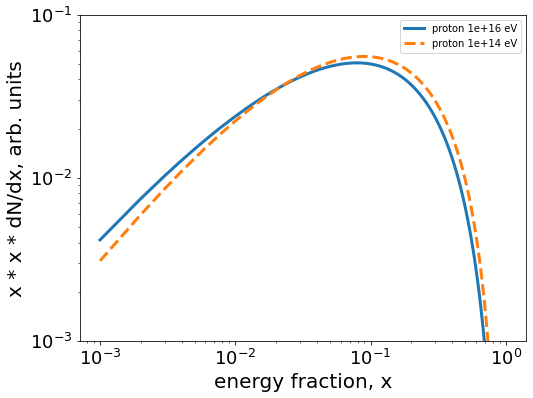

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(
    F_gamma_table16[:, 0], F_gamma_table16[:, 1],
    marker=None,
    linestyle='-',
    linewidth=3,
    label='proton 1e+16 eV'
)

plt.plot(
    F_gamma_table14[:, 0], F_gamma_table14[:, 1],
    marker=None,
    linestyle='--',
    linewidth=3,
    label='proton 1e+14 eV'
)

plt.xlabel('energy fraction, ' + 'x', fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('x * x * dN/dx, ' + 'arb. units', fontsize=20)
plt.yticks(fontsize=18)
ax.set_xscale('log')
ax.set_ylim(1.0e-03, 1.0e-01)
ax.set_yscale('log')
plt.legend(fontsize=10)
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/check_scaling.pdf')

## Functions for gamma-ray spectrum calculations (from pp-interactions)

In [37]:
def sigma_pp_inelastic_cross_section(e):
    """
    proton-proton cross section:
    see http://dx.doi.org/10.1103/PhysRevD.74.034018
    (Kelner et al. (2006), eq. (79))
    """
    e = e.to(u.TeV)
    L = np.log(e.value)
    e_thr = (1.22e-03 * u.TeV).to(u.eV)
    return ((34.3 + 1.88 * L + 0.25 * L**2) *
            (1.0 - (e_thr / e)**4)**2 * 1.0e-27 * u.cm**2)

# F_gamma_table = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e16")
F_gamma_table = np.loadtxt("data/Processes-Timur/ProtonProtonGamma-1e14")
logx1 = np.log10(F_gamma_table[:, 0])
logy1 = np.log10(F_gamma_table[:, 1])
log_F_gamma_interpol = interpolate.interp1d(logx1, logy1,
                                            kind='linear',
                                            bounds_error=False,
                                            fill_value='extrapolate')

def F_gamma_interpol_aux(x):
    xl = np.log10(x)
    return ((10.0**log_F_gamma_interpol(xl)) / x**2)

def F_gamma_approx(E_gamma, E_proton):
    """
    Returns the spectrum of gamma rays from proton-proton interactions
    in frame of the scaling (1 / E_proton) approximation.
    """
    x = E_gamma / E_proton
    return (F_gamma_interpol_aux(x) / E_proton)

In [38]:
proton_normalization = 7e-16 * u.eV**(-1) * u.s**(-1) * u.cm**(-2)

In [39]:
proton_energy = np.logspace(13.50, 14.77, 100) * u.eV
proton_spectrum = spec.power_law(
    proton_energy,
    2.0,
    norm=proton_normalization,
    en_ref=en_ref * u.eV)
proton_column_density = 1.0e+23 * u.cm**(-2)
proton_tau = (proton_column_density *
              sigma_pp_inelastic_cross_section(proton_energy))
print("proton tau = ", proton_tau)
proton_spectrum_interacted = proton_spectrum * (1.0 -
                                                np.exp(-proton_tau))

proton tau =  [0.00437756 0.00438824 0.00439896 0.00440972 0.00442053 0.00443138
 0.00444227 0.00445321 0.00446419 0.00447522 0.00448628 0.0044974
 0.00450855 0.00451975 0.004531   0.00454228 0.00455361 0.00456499
 0.0045764  0.00458787 0.00459937 0.00461092 0.00462251 0.00463415
 0.00464583 0.00465755 0.00466932 0.00468113 0.00469298 0.00470488
 0.00471682 0.0047288  0.00474083 0.00475291 0.00476502 0.00477718
 0.00478938 0.00480163 0.00481392 0.00482625 0.00483863 0.00485105
 0.00486352 0.00487603 0.00488858 0.00490117 0.00491381 0.00492649
 0.00493922 0.00495199 0.00496481 0.00497766 0.00499056 0.00500351
 0.0050165  0.00502953 0.0050426  0.00505572 0.00506889 0.00508209
 0.00509534 0.00510864 0.00512197 0.00513535 0.00514878 0.00516225
 0.00517576 0.00518931 0.00520291 0.00521655 0.00523024 0.00524397
 0.00525774 0.00527156 0.00528542 0.00529933 0.00531327 0.00532727
 0.0053413  0.00535538 0.0053695  0.00538367 0.00539788 0.00541213
 0.00542643 0.00544077 0.00545515 0.00546958 0.00

In [40]:
# folder_hybrid_gamma = "test54_primary_gamma_field_30000_eps_thr=1e+05eV_with_losses_below_threshold_7e+07---1e+14eV_photon_max=None"
folder_hybrid_gamma = "test55_primary_gamma_field_30000_eps_thr=1e+05eV_no_losses_below_threshold_1e+10---5e+14eV_photon_max=None"
energy_bins_fit_hybrid_gamma_from_protons = np.logspace(8, np.log10(5e+14), 49)
primary_energy_bins_fit_hybrid_gamma_from_protons = np.logspace(
    np.log10(1.0e+10),
    np.log10(5.0e+14),
    49
)
en_primary_min_in_mc_gamma_from_protons = 1.0e+10 #7.0e+07
en_primary_max_in_mc_gamma_from_protons = 5.0e+14
number_of_particles_hybrid_gamma_from_protons = (
    30_000 *
    np.log(primary_energy_bins_fit_hybrid_gamma_from_protons[-1] /
           primary_energy_bins_fit_hybrid_gamma_from_protons[0]) /
    np.log(en_primary_max_in_mc_gamma_from_protons /
           en_primary_min_in_mc_gamma_from_protons)
)

In [41]:
gamma_from_protons_energy = np.logspace(np.log10(primary_energy_bins_fit_hybrid_gamma_from_protons[0]),
                                        np.log10(primary_energy_bins_fit_hybrid_gamma_from_protons[-1]),
                                        100) * u.eV
gamma_from_protons_spectrum = (np.array(list(map(
    lambda z: simps(F_gamma_approx(z.value,
                                   proton_energy.value) *
                    proton_spectrum_interacted.value,
                    proton_energy.value),
    gamma_from_protons_energy))) *
    F_gamma_approx(gamma_from_protons_energy,
                   proton_energy[0]).unit *
    proton_spectrum[0].unit *
    proton_energy[0].unit)

In [42]:
f_aux_gamma_from_protons_spectrum = interpolate.interp1d(
    np.log10(gamma_from_protons_energy.value),
    np.log10(gamma_from_protons_spectrum.value),
    kind='linear',
    bounds_error=False,
    fill_value='extrapolate'
)

def gamma_from_protons_spectrum_interpolated(energy, c):
    return(10.0**(f_aux_gamma_from_protons_spectrum(np.log10(
        energy
    ))) * c)

## Function to fit the data with the 2-component model

In [43]:
def fit_data_with_monte_carlo(f, x_data, y_data, y_sigma, p0,
                              number_of_hidden_parameters=0):
    popt, pcov = curve_fit(f, x_data, y_data,
                           p0=p0, sigma=y_sigma,
                           absolute_sigma=True,
                           check_finite=True,
                           ftol=1e-11,
                           xtol=1e-11,
                           gtol=1e-11)  # , bounds=bounds)
    print("----------------------------------------------------------")
    print("The following parameters have been obtained:")
    for i, parameter in enumerate(popt):
        print(
            "parameter number {:d} = {:e} +/- {:e}".format(
                i, popt[i], np.sqrt(np.diag(pcov)[i])))
    ####################################################################
    # calculate chi^2
    data_predicted_from_fit = f(x_data, *popt)
    chi_sq = np.sum((y_data - data_predicted_from_fit)**2 / y_sigma**2)
    ndof = (y_data.shape[0] - len(popt) - 1) - \
        number_of_hidden_parameters
    print('ndof = {:d}'.format(ndof))
    print("chi_sq / n.d.o.f. = {:f}".format(
        chi_sq /
        ndof)
    )
    return (popt, np.sqrt(np.diag(pcov)), chi_sq, ndof)

## Load data from the Monte-Carlo simulations

In [44]:
hist_precalc_hybrid_gamma_from_protons = make_sed_from_monte_carlo_cash_files(
    folder_hybrid_gamma,
    energy_bins_fit_hybrid_gamma_from_protons,  # array-like
    primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
    cascade_type_of_particles='all',
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    new_spectrum=None,
    new_params=None,
    original_keyargs={},
    new_keyargs={},
    reweight_array='primary',
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    particles_of_interest='gamma',  # or 'electron'
    density=False,
    verbose=False,
    output='histogram_2d_precalculated',
    device='cpu'
)

## 2-component model SED function

In [47]:
def model_sed_from_monte_carlo_hybrid_gamma_from_protons(
    en_observable,
    norm_gamma_from_protons,
    alpha_null,
    beta_null,
    norm_null_scaled,
    en_ref=en_ref,
    energy_bins_mc=energy_bins_fit_hybrid_gamma_from_protons,
    primary_energy_bins_mc=primary_energy_bins_fit_hybrid_gamma_from_protons,
    redshift=z,
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    histogram_2d_precalculated=hist_precalc_hybrid_gamma_from_protons,
    scale_norm=scale_norm
):
    e_cascade, sed_cascade = make_SED(
        None,
        energy_bins_mc,
        None,
        primary_energy_bins=primary_energy_bins_mc,
        original_spectrum=original_spectrum,
        original_params=original_params,
        new_spectrum=gamma_from_protons_spectrum_interpolated,
        new_params=[norm_gamma_from_protons, ],
        original_keyargs={},
        new_keyargs={},
        reweight_array='primary',
        number_of_particles=number_of_particles,
        density=False,
        histogram_2d_precalculated=histogram_2d_precalculated,
        old=False
    )
    sed_cascade[sed_cascade <= 0] = 1.0e-40
    en_source = en_observable * (1.0 + redshift)
    sed_cascade = spec.to_current_energy(
        en_source,
        e_cascade, sed_cascade
    )
    ###################################################################
    sed_null = en_source**2 * my_spec(en_source,
                                      alpha_null, beta_null, norm_null_scaled,
                                      scale_norm=scale_norm)
    ###################################################################
    sed = sed_cascade + sed_null
    sed = sed * np.exp(-ebl.tau_gilmore(en_observable * u.eV,
                                        redshift))
    sed = sed / (1.0 + redshift)  # AHNTUNG ATTENTION !!!
    return sed

## Fit the 2-component model SED to the data

In [48]:
p0_hybrid_gamma_from_protons = [0.8, # norm_gamma_from_protons,
                                2.66, # alpha_null
                                0.067, # beta_null
                                2.8] # norm_null
popt_hybrid_gamma_from_protons, perr_hybrid_gamma_from_protons, chisq_hybrid_gamma_from_protons, ndof_hybrid_gamma_from_protons = fit_data_with_monte_carlo(
    model_sed_from_monte_carlo_hybrid_gamma_from_protons,
    x_data[0], y_data[0], yerr_stat[0],
    p0_hybrid_gamma_from_protons,
    number_of_hidden_parameters=0)
sed_hybrid_gamma_from_protons = model_sed_from_monte_carlo_hybrid_gamma_from_protons(
    en_observable,
    *popt_hybrid_gamma_from_protons
)
gamma_from_protons_sed = (gamma_from_protons_spectrum *
                          gamma_from_protons_energy**2 *
                          popt_hybrid_gamma_from_protons[0])

----------------------------------------------------------
The following parameters have been obtained:
parameter number 0 = 2.800742e-01 +/- 3.703658e-02
parameter number 1 = 2.789581e+00 +/- 2.539298e-02
parameter number 2 = 8.880521e-02 +/- 4.373517e-03
parameter number 3 = 2.265953e+00 +/- 8.281985e-02
ndof = 13
chi_sq / n.d.o.f. = 1.428593


In [49]:
filt_low = np.logical_and((en_observable < 1.0e+10),
                          (en_observable >= 3.0e+8))
en_obs_low = en_observable[filt_low]
sed_low = sed_hybrid_gamma_from_protons[filt_low]

filt_high = (en_observable >= 1.0e+10)
en_obs_high = en_observable[filt_high]
sed_high = sed_hybrid_gamma_from_protons[filt_high]

In [50]:
integral_energy_low = simps(sed_low / en_obs_low, en_obs_low)
print("Full energy below 10 GeV: {:.3e}".format(
    integral_energy_low
))

integral_energy_high = simps(sed_high / en_obs_high, en_obs_high)
print("Full energy above 10 GeV: {:.3e}".format(
    integral_energy_high
))

Full energy below 10 GeV: 1.629e+02
Full energy above 10 GeV: 2.270e+01


In [51]:
photon_count_low = simps(sed_low / en_obs_low**2, en_obs_low)
print("Number of photons below 10 GeV: {:.3e}".format(
    photon_count_low
))

photon_count_high = simps(sed_high / en_obs_high**2, en_obs_high)
print("Number of photons above 10 GeV: {:.3e}".format(
    photon_count_high
))

Number of photons below 10 GeV: 2.060e-07
Number of photons above 10 GeV: 9.812e-10


In [52]:
print("Final proton_normalization = {:.3e} +/- {:.3e}".format(
    proton_normalization * popt_hybrid_gamma_from_protons[0],
    perr_hybrid_gamma_from_protons[0] * proton_normalization
))

Final proton_normalization = 1.961e-16 1 / (cm2 eV s) +/- 2.593e-17 1 / (cm2 eV s)


In [53]:
p_value_hybrid_gamma_from_protons = stats.chi2.sf(
    chisq_hybrid_gamma_from_protons,
    df=ndof_hybrid_gamma_from_protons
)
print("p_value_hybrid_gamma_from_protons = {:.4f}".format(
    p_value_hybrid_gamma_from_protons
))
significance_hybrid_gamma_from_protons = spec.get_significance_2_tailed(
    p_value_hybrid_gamma_from_protons
)
print("significance_hybrid_gamma_from_protons = {:.2f} sigma".format(
    significance_hybrid_gamma_from_protons
))

p_value_hybrid_gamma_from_protons = 0.1370
significance_hybrid_gamma_from_protons = 1.49 sigma


## Obtain the second component (from the Monte-Carlo simulation) with the best-fit spectrum parameters

In [54]:
e_all_mc_gamma_from_protons, sed_all_mc_gamma_from_protons = make_sed_from_monte_carlo_cash_files(
    folder_hybrid_gamma,
    energy_bins_fit_hybrid_gamma_from_protons,  # array-like
    primary_energy_bins=primary_energy_bins_fit_hybrid_gamma_from_protons,
    cascade_type_of_particles='all',
    original_spectrum=spec.power_law,
    original_params=[1.0, 1.0, 1.0],
    new_spectrum=gamma_from_protons_spectrum_interpolated,
    new_params=[popt_hybrid_gamma_from_protons[0], ],
    original_keyargs={},
    new_keyargs={},
    reweight_array='primary',
    number_of_particles=number_of_particles_hybrid_gamma_from_protons,
    particles_of_interest='gamma',  # or 'electron'
    density=False,
    verbose=False,
    output='sed',
    device='cpu'
)
e_all_mc_gamma_from_protons_observable = (e_all_mc_gamma_from_protons /
                                          (1.0 + z))
sed_all_mc_gamma_from_protons_observable = (
    sed_all_mc_gamma_from_protons /
    (1.0 + z) *
    np.exp(-ebl.tau_gilmore(
        e_all_mc_gamma_from_protons_observable * u.eV,
        z)
    ))

Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV
Warning!energy is more than maximum possible! Applying tau for 100 TeV


## Obtain the first component with the best-fit spectrum parameters

In [55]:
sed_null_model2 = model0_SED(en_observable, *popt_hybrid_gamma_from_protons[1:])
# en_source_null_model2 = en_observable * (1.0 + z)
# sed_source_null_model2 = (my_spec(en_source_null_model2,
#                                  *p0_hybrid_gamma_from_protons[1:]) *
#                           en_source_null_model2**2)

## Residuals

In [56]:
sed_hybrid_gamma_from_protons_at_fermi = spec.to_current_energy(data_en_fermi,
                                                                en_observable,
                                                                sed_hybrid_gamma_from_protons)
residual_fermi2 = ((data_sed_fermi - sed_hybrid_gamma_from_protons_at_fermi) /
                   sed_hybrid_gamma_from_protons_at_fermi)

In [57]:
yerr_residuals_fermi_relative2 = [yerr_stat_fermi[0] / sed_hybrid_gamma_from_protons_at_fermi,
                                  yerr_stat_fermi[1] / sed_hybrid_gamma_from_protons_at_fermi]

In [58]:
sed_hybrid_gamma_from_protons_at_magic = []
residual_magic2 = []
for i in range(0, len(optimized)):
    if i == 0:
        magic_sed = data_sed_magic
    elif i == 1:
        magic_sed = syst_magic_sed_down
    elif i == 2:
        magic_sed = syst_magic_sed_up
    sed_hybrid_gamma_from_protons_at_magic.append(
        spec.to_current_energy(
        magic_energy[i],
        en_observable,
        sed_hybrid_gamma_from_protons)
    )
    residual_magic2.append(
        ((magic_sed - sed_hybrid_gamma_from_protons_at_magic[i]) /
         sed_hybrid_gamma_from_protons_at_magic[i])
    )

In [59]:
yerr_residuals_magic_relative2 = []
for i in range(0, len(optimized)):
    yerr_residuals_magic_relative.append(
        [yerr_stat_magic[0] / sed_hybrid_gamma_from_protons_at_magic[i],
         yerr_stat_magic[1] / sed_hybrid_gamma_from_protons_at_magic[i]]
    )

## Plotting the results

In [61]:
fig, ax1 = plt.subplots(1, 1,
                        figsize=(16, 10),
                        sharex=False,
                        sharey=False,
                        dpi=600)

ax1.plot(
    en_observable, sed_hybrid_gamma_from_protons,
    marker=None,
    linestyle='-',
    linewidth=linewidth,
    color='brown',
    label='2-component model, Earth frame'
)

filt_null_model2 = (en_observable < 5e+11)
ax1.plot(
    en_observable[filt_null_model2], sed_null_model2[filt_null_model2],
    marker=None,
    linestyle='--',
    linewidth=linewidth,
    color='k',
    label='1st component, Earth frame'
)

# ax1.plot(
#     en_source_null_model2, sed_source_null_model2,
#     marker=None,
#     linestyle=':',
#     linewidth=3,
#     color='k',
#     zorder=2,
#     label='1st component, source frame, before EBL absorption'
# )

ax1.plot(
    e_all_mc_gamma_from_protons_observable, sed_all_mc_gamma_from_protons_observable,
    marker=None,
    linestyle='--',
    linewidth=linewidth,
    color='r',
    label='2nd component, Earth frame'
)

# ax1.plot(
#     e_all_mc_gamma_from_protons, sed_all_mc_gamma_from_protons,
#     marker=None,
#     linestyle=':',
#     linewidth=3,
#     color='r',
#     label='2nd component, source frame, before EBL absorption'
# )

ax1.plot(
        gamma_from_protons_energy, gamma_from_protons_sed,
        marker=None,
        linestyle='-.',
        linewidth=linewidth,
        color='purple',
        zorder=2,
        label='Gamma rays from pp, source frame'
)

ax1.errorbar(data_en_fermi, data_sed_fermi,
             yerr=yerr_stat_fermi, xerr=None, fmt='o', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, color='b', zorder=100.0,
             label='Fermi-LAT data')

ax1.errorbar(data_en_magic, data_sed_magic,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             label='MAGIC data',
             color=magic_colors[0])

ax1.errorbar(syst_magic_en_down, syst_magic_sed_down,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[1])

ax1.errorbar(syst_magic_en_up, syst_magic_sed_up,
             yerr=yerr_stat_magic, xerr=None, fmt='s', linewidth=0, elinewidth=2,
             capsize=1, barsabove=False, markersize=markersize,
             errorevery=1, capthick=1, zorder=100.0,
             fillstyle='none',
             color=magic_colors[-1])

# ax1.fill_between(
#     syst_magic_en_common,
#     syst_magic_interpolated_down_function(syst_magic_en_common),
#     syst_magic_interpolated_up_function(syst_magic_en_common),
#     alpha=0.37,
#     color='orange',
#     label='MAGIC systematic uncertainty'
# )
##############################################################################################################
ax1.set_ylabel('SED ' + r'[eV cm$^{-2}$s$^{-1}$]', fontsize=fontsize_axis_title)
ax1.set_xlabel('Energy [eV]', fontsize=fontsize_axis_title)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.0e+08, 1.0e+12)
ax1.set_ylim(1.0e-01, 2.0e+02)
ax1.grid()
ax1.legend(fontsize=fontsize_legend + 1, loc="lower left")
##############################################################################################################
# ax2.plot(np.logspace(8, 12), np.zeros((50, )),
#          color='black',
#          linewidth=linewidth,
#          linestyle='-')

# ax2.errorbar(data_en_fermi, residual_fermi2,
#              yerr=yerr_residuals_fermi_relative, xerr=None, fmt='o', linewidth=0, elinewidth=2,
#              capsize=1, barsabove=False, markersize=markersize,
#              errorevery=1, capthick=1,
#              color='b',
#              #label='Fermi-LAT, 2-component model',
#              zorder=400)

# for i in range(0, len(optimized)):
#     if i == 0:
#         fillstyle = "full"
#     else:
#         fillstyle = "none"
#     ax2.errorbar(magic_energy[i], residual_magic2[i],
#                  yerr=yerr_residuals_magic_relative[i], xerr=None, fmt='s', linewidth=0, elinewidth=2,
#                  capsize=1, barsabove=False, markersize=markersize,
#                  errorevery=1, capthick=1,
#                  color=magic_colors[i],
#                  fillstyle=fillstyle)

# ax2.set_xlim(1.0e+08, 1.0e+12)
# ax2.set_xscale('log')
# ax2.tick_params(axis='y', which='major', labelsize=fontsize_ticks)
# ax2.tick_params(axis='x', which='major', labelsize=fontsize_ticks)
# ax2.set_ylabel('Relative residuals', fontsize=fontsize_axis_title)
# ax2.set_xlabel('Energy [eV]', fontsize=fontsize_axis_title)
# # ax2.legend(fontsize=fontsize_legend)
# ax2.grid()

plt.tight_layout()
plt.show()
# fig.savefig('test_figures/PKS1510-089/journal/fig5_v8.pdf')
# fig.savefig('test_figures/PKS1510-089/journal/fig5_v8.png')

In [70]:
# for_Timur_observable = np.concatenate(
#     [e_all_mc_gamma_from_protons_observable.reshape(e_all_mc_gamma_from_protons_observable.shape[0], 1),
#      sed_all_mc_gamma_from_protons_observable.reshape(sed_all_mc_gamma_from_protons_observable.shape[0], 1)],
#     axis=1
# )
# for_Timur_observable
# np.savetxt("test_figures/PKS1510-089/journal/2nd_component_Earth.txt",
#            for_Timur_observable,
#            fmt="%.6e")

In [71]:
# for_Timur_source = np.concatenate(
#     [e_all_mc_gamma_from_protons.reshape(e_all_mc_gamma_from_protons.shape[0], 1),
#      sed_all_mc_gamma_from_protons.reshape(sed_all_mc_gamma_from_protons.shape[0], 1)],
#     axis=1
# )
# for_Timur_source
# np.savetxt("test_figures/PKS1510-089/journal/2nd_component_source.txt",
#            for_Timur_source,
#            fmt="%.6e")